In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [5]:
df = pd.read_csv("dataset_scaled.csv")

In [6]:
X = df.drop(['name', 'Quality'], axis=1)
y = df['Quality']

In [7]:
# Nested CV configuration
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# 3. Hyperparameter Search Spaces
rf_params = {
    "model__n_estimators": [100, 200, 500, 800],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.2, 0.5],
}

svr_params = {
    "model__C": [0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 0.01, 0.001],
    "model__epsilon": [0.01, 0.05, 0.1],
    "model__kernel": ["rbf"],
}

lgb_params = {
    "model__num_leaves": [15, 31, 63],
    "model__learning_rate": [0.005, 0.01, 0.05],
    "model__n_estimators": [200, 500, 800],
    "model__min_data_in_leaf": [10, 20, 50],
}

In [9]:
def make_rf():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(random_state=42))
    ])

def make_svr():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR())
    ])

def make_lgb():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", lgb.LGBMRegressor(objective="mae", random_state=42))
    ])

In [10]:
# evaluate metrics
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    pcc, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, pcc, r2


In [11]:
# evaluate metrics
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    pcc, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # RAE (Relative Absolute Error)
    baseline_mae = mean_absolute_error(y_true, np.full_like(y_true, y_true.mean()))
    rae = mae / baseline_mae if baseline_mae != 0 else 0
    return mae, pcc, r2, rae

In [12]:
results = {"RF": [], "SVR": [], "LGBM": [], "STACK": []}
all_preds = {"RF": [], "SVR": [], "LGBM": [], "STACK": []}
all_actual = []

fold = 1

for train_idx, test_idx in outer_cv.split(X):
    print("="*70)
    print(f" OUTER FOLD {fold}")
    print("="*70)

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ---------------- Random Forest ----------------
    rf = make_rf()
    rf_search = RandomizedSearchCV(
        rf, rf_params, n_iter=20, cv=inner_cv,
        scoring="neg_mean_absolute_error", random_state=42, n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    rf_pred = rf_search.predict(X_test)
    results["RF"].append(compute_metrics(y_test, rf_pred))
    all_preds["RF"].extend(rf_pred)

    # ---------------- SVR ----------------
    svr = make_svr()
    svr_search = RandomizedSearchCV(
        svr, svr_params, n_iter=20, cv=inner_cv,
        scoring="neg_mean_absolute_error", random_state=42, n_jobs=-1
    )
    svr_search.fit(X_train, y_train)
    svr_pred = svr_search.predict(X_test)
    results["SVR"].append(compute_metrics(y_test, svr_pred))
    all_preds["SVR"].extend(svr_pred)

    # ---------------- LightGBM ----------------
    lgbm = make_lgb()
    lgb_search = RandomizedSearchCV(
        lgbm, lgb_params, n_iter=20, cv=inner_cv,
        scoring="neg_mean_absolute_error", random_state=42, n_jobs=-1
    )
    lgb_search.fit(X_train, y_train)
    lgb_pred = lgb_search.predict(X_test)
    results["LGBM"].append(compute_metrics(y_test, lgb_pred))
    all_preds["LGBM"].extend(lgb_pred)

    # ---------------- Stacking ----------------
    final_rf = rf_search.best_estimator_
    final_svr = svr_search.best_estimator_

    stack = StackingRegressor(
        estimators=[("rf", final_rf), ("svr", final_svr)],
        final_estimator=LinearRegression()
    )
    stack.fit(X_train, y_train)
    stack_pred = stack.predict(X_test)
    results["STACK"].append(compute_metrics(y_test, stack_pred))
    all_preds["STACK"].extend(stack_pred)

    all_actual.extend(y_test)
    fold += 1

 OUTER FOLD 1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 18
[LightGBM] [Info] Start training from score 3.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [13]:
def summarize(model):
    m = np.array(results[model])
    return m[:,0].mean(), m[:,1].mean(), m[:,2].mean()

summary = pd.DataFrame({
    "Model": ["RF", "SVR", "LGBM", "STACK"],
    "MAE": [summarize("RF")[0], summarize("SVR")[0], summarize("LGBM")[0], summarize("STACK")[0]],
    "PCC": [summarize("RF")[1], summarize("SVR")[1], summarize("LGBM")[1], summarize("STACK")[1]],
    "R2":  [summarize("RF")[2], summarize("SVR")[2], summarize("LGBM")[2], summarize("STACK")[2]],
})

print("\nFINAL SUMMARY:")


FINAL SUMMARY:


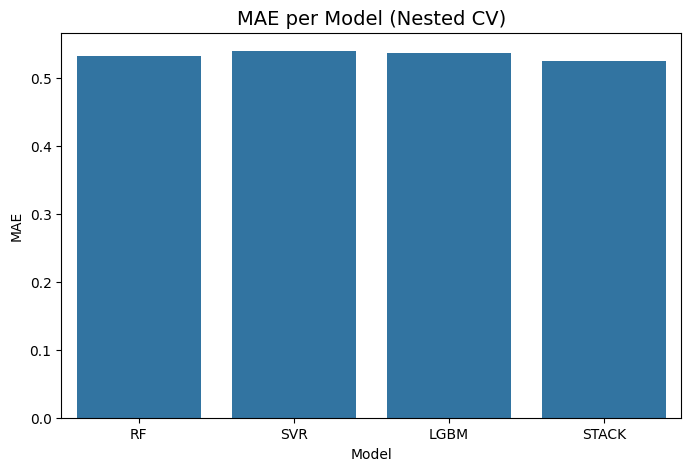

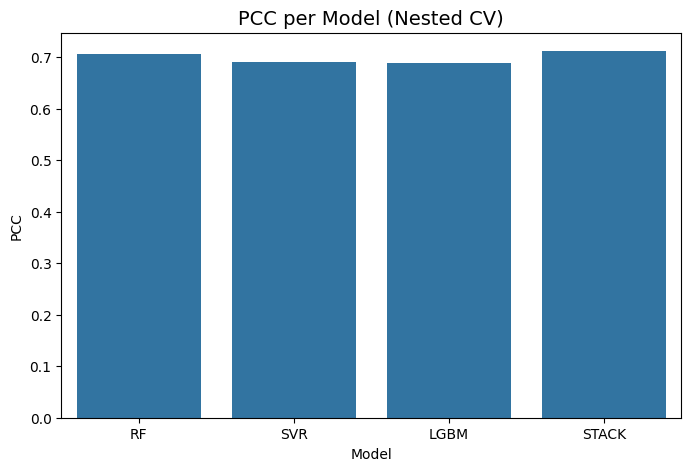

In [14]:
# ---------------- BARPLOT MAE ----------------
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="MAE", data=summary)
plt.title("MAE per Model (Nested CV)", fontsize=14)
plt.savefig("barplot_mae.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------- BARPLOT PCC ----------------
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="PCC", data=summary)
plt.title("PCC per Model (Nested CV)", fontsize=14)
plt.savefig("barplot_pcc.png", dpi=300, bbox_inches='tight')
plt.show()

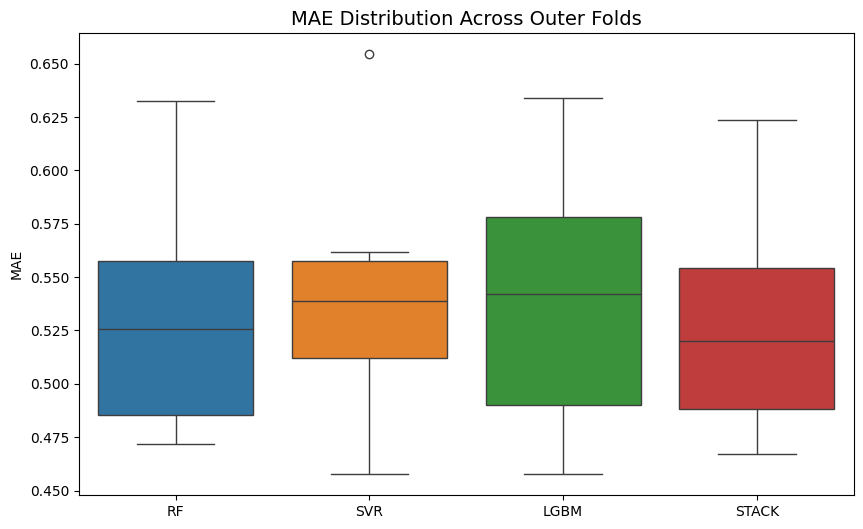

In [15]:
# ---------------- BOXPLOT MAE ----------------
mae_data = pd.DataFrame({
    "RF": [m[0] for m in results["RF"]],
    "SVR": [m[0] for m in results["SVR"]],
    "LGBM": [m[0] for m in results["LGBM"]],
    "STACK": [m[0] for m in results["STACK"]],
})

plt.figure(figsize=(10,6))
sns.boxplot(data=mae_data)
plt.title("MAE Distribution Across Outer Folds", fontsize=14)
plt.ylabel("MAE")
plt.savefig("boxplot_mae_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

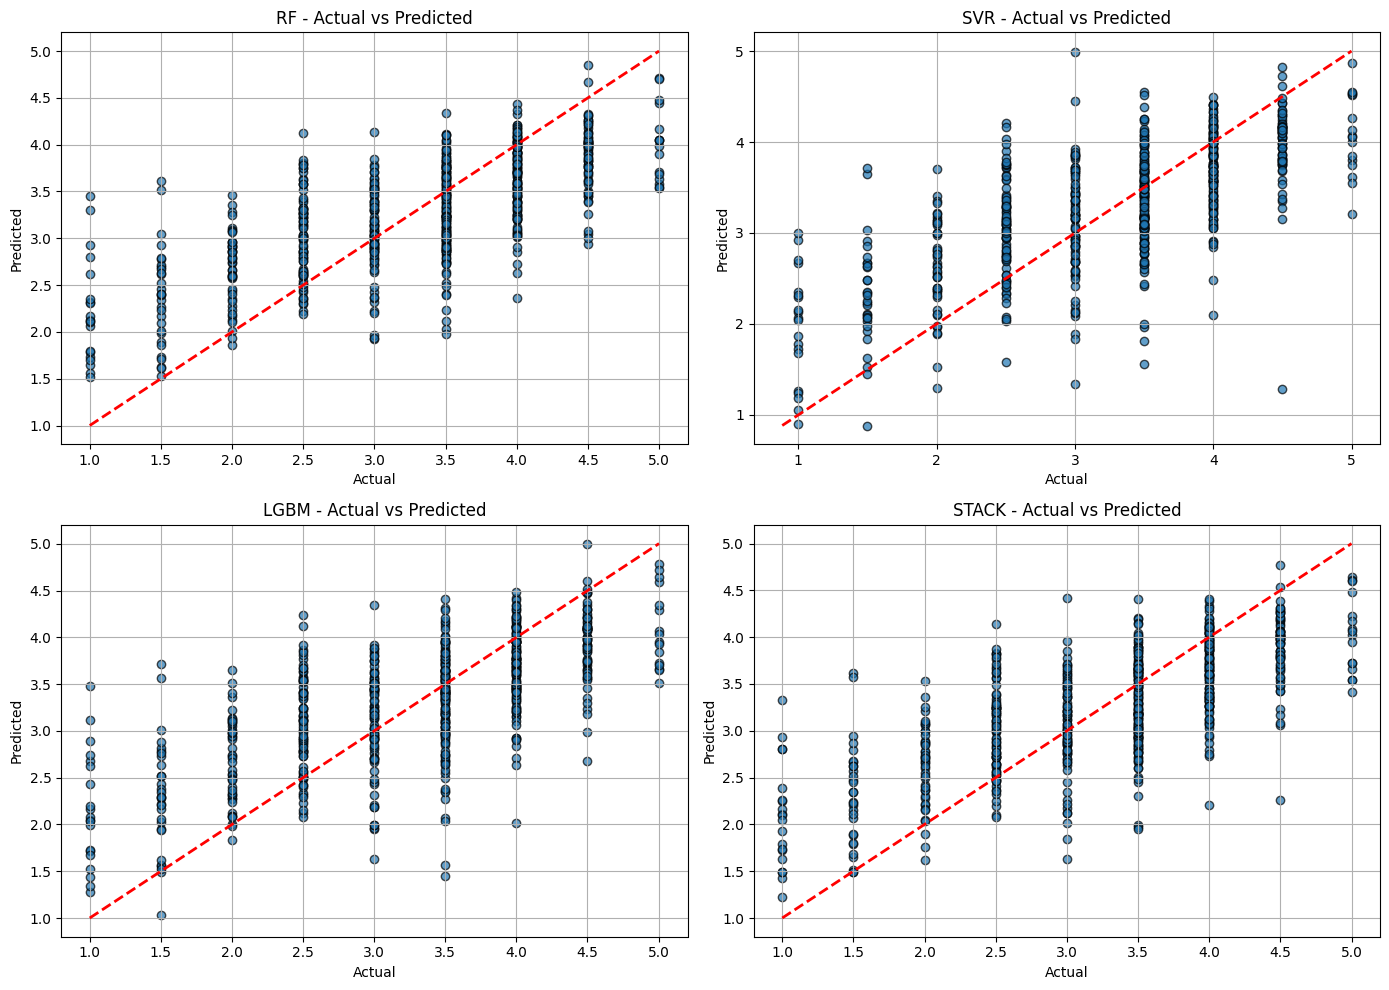

In [16]:
# ---------------- SCATTER ACTUAL vs PREDICTED ----------------
actual = np.array(all_actual)
models = ["RF", "SVR", "LGBM", "STACK"]

plt.figure(figsize=(14,10))
for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    pred = np.array(all_preds[model])
    
    plt.scatter(actual, pred, alpha=0.7, edgecolors="black")
    
    min_v = min(actual.min(), pred.min())
    max_v = max(actual.max(), pred.max())
    plt.plot([min_v, max_v], [min_v, max_v], "r--", lw=2)
    
    plt.title(f"{model} - Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)

plt.tight_layout()
plt.savefig("scatter_actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

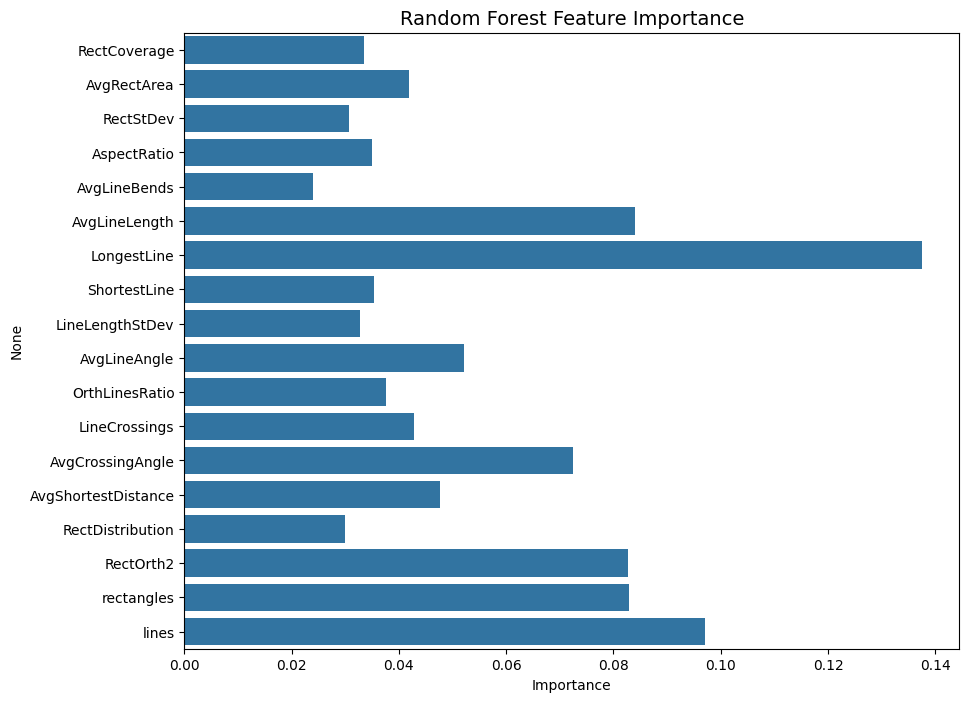

In [17]:
# ---------------- FEATURE IMPORTANCE RF ----------------
best_rf = rf_search.best_estimator_.named_steps["model"]
importances = best_rf.feature_importances_

plt.figure(figsize=(10,8))
sns.barplot(x=importances, y=X.columns)
plt.title("Random Forest Feature Importance", fontsize=14)
plt.xlabel("Importance")
plt.savefig("feature_importance_rf.png", dpi=300, bbox_inches='tight')
plt.show()

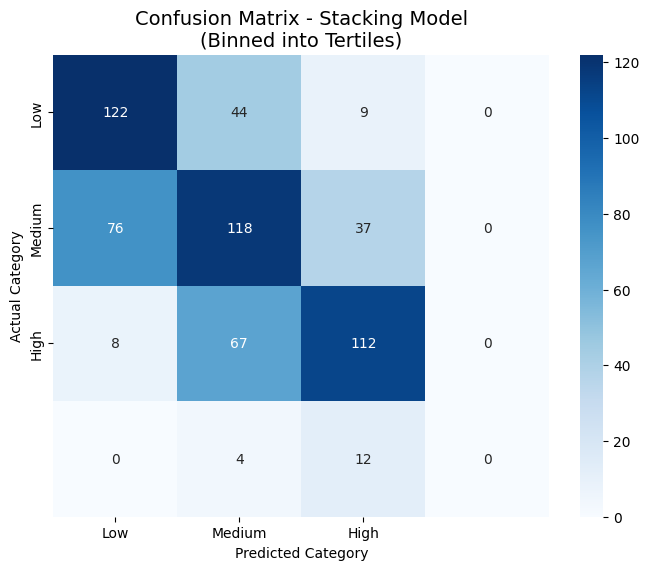


Binned Classification Accuracy: 0.5780


In [18]:
# ---------------- CONFUSION MATRIX for STACKING (Binned) ----------------
from sklearn.metrics import confusion_matrix

# Convert continuous values to categories using quantiles
actual_array = np.array(all_actual)
stack_pred_array = np.array(all_preds["STACK"])

# Create bins based on quantiles (tertiles: Low, Medium, High)
bins = np.percentile(actual_array, [0, 33.33, 66.67, 100])
bins[0] -= 0.001  # Avoid edge case

# Categorize actual and predicted values
actual_binned = np.digitize(actual_array, bins) - 1
pred_binned = np.digitize(stack_pred_array, bins) - 1

# Create confusion matrix
cm = confusion_matrix(actual_binned, pred_binned)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Stacking Model\n(Binned into Tertiles)', fontsize=14)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.savefig("confusion_matrix_stacking.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate accuracy for binned predictions
accuracy = np.sum(actual_binned == pred_binned) / len(actual_binned)
print(f"\nBinned Classification Accuracy: {accuracy:.4f}")

In [19]:
print("\n=== MAE & PCC & RAE per Fold ===\n")

for model in ["RF", "SVR", "LGBM", "STACK"]:
    print(f"\nMODEL: {model}")
    print("==============================")
    for i, (mae, pcc, r2, rae) in enumerate(results[model], start=1):
        print(f"Fold {i}:  MAE = {mae:.4f},   PCC = {pcc:.4f},   RAE = {rae:.4f}")


=== MAE & PCC & RAE per Fold ===


MODEL: RF
Fold 1:  MAE = 0.4824,   PCC = 0.7714,   RAE = 0.6147
Fold 2:  MAE = 0.4717,   PCC = 0.6481,   RAE = 0.7139
Fold 3:  MAE = 0.5144,   PCC = 0.6337,   RAE = 0.7142
Fold 4:  MAE = 0.6324,   PCC = 0.7648,   RAE = 0.6562
Fold 5:  MAE = 0.4938,   PCC = 0.7736,   RAE = 0.6451
Fold 6:  MAE = 0.5374,   PCC = 0.7292,   RAE = 0.6845
Fold 7:  MAE = 0.5442,   PCC = 0.6724,   RAE = 0.6759
Fold 8:  MAE = 0.5923,   PCC = 0.7480,   RAE = 0.7236
Fold 9:  MAE = 0.4825,   PCC = 0.7469,   RAE = 0.7216
Fold 10:  MAE = 0.5617,   PCC = 0.5831,   RAE = 0.8391

MODEL: SVR
Fold 1:  MAE = 0.4940,   PCC = 0.7276,   RAE = 0.6295
Fold 2:  MAE = 0.5314,   PCC = 0.5823,   RAE = 0.8042
Fold 3:  MAE = 0.5618,   PCC = 0.5313,   RAE = 0.7800
Fold 4:  MAE = 0.6544,   PCC = 0.7689,   RAE = 0.6791
Fold 5:  MAE = 0.5073,   PCC = 0.7518,   RAE = 0.6628
Fold 6:  MAE = 0.5258,   PCC = 0.7145,   RAE = 0.6698
Fold 7:  MAE = 0.5462,   PCC = 0.7047,   RAE = 0.6783
Fold 8:  MAE = 0.5590, 

In [20]:
print("\n=== SUMMARY (AVERAGE METRICS) ===\n")

for model in ["RF", "SVR", "LGBM", "STACK"]:
    arr = np.array(results[model])
    mae_mean = arr[:,0].mean()
    pcc_mean = arr[:,1].mean()
    rae_mean = arr[:,3].mean()
    print(f"{model:6s}  AVG MAE = {mae_mean:.4f}   |   AVG PCC = {pcc_mean:.4f}   |   AVG RAE = {rae_mean:.4f}")


=== SUMMARY (AVERAGE METRICS) ===

RF      AVG MAE = 0.5313   |   AVG PCC = 0.7071   |   AVG RAE = 0.6989
SVR     AVG MAE = 0.5391   |   AVG PCC = 0.6917   |   AVG RAE = 0.7098
LGBM    AVG MAE = 0.5369   |   AVG PCC = 0.6880   |   AVG RAE = 0.7077
STACK   AVG MAE = 0.5252   |   AVG PCC = 0.7121   |   AVG RAE = 0.6915


In [21]:
summary_table = pd.DataFrame({
    "MAE per Fold": [ [m[0] for m in results[model]] for model in ["RF","SVR","LGBM","STACK"] ],
    "PCC per Fold": [ [m[1] for m in results[model]] for model in ["RF","SVR","LGBM","STACK"] ],
    "RAE per Fold": [ [m[3] for m in results[model]] for model in ["RF","SVR","LGBM","STACK"] ],
    "AVG_MAE": [ np.mean([m[0] for m in results[model]]) for model in ["RF","SVR","LGBM","STACK"] ],
    "AVG_PCC": [ np.mean([m[1] for m in results[model]]) for model in ["RF","SVR","LGBM","STACK"] ],
    "AVG_RAE": [ np.mean([m[3] for m in results[model]]) for model in ["RF","SVR","LGBM","STACK"] ],
}, index=["RF", "SVR", "LGBM", "STACK"])

print(summary_table)

                                            MAE per Fold  \
RF     [0.4823658070464952, 0.47174963587058416, 0.51...   
SVR    [0.49398446927180023, 0.5314348110028847, 0.56...   
LGBM   [0.457629420827941, 0.49847524585291575, 0.543...   
STACK  [0.4809337921270511, 0.48623223851277525, 0.51...   

                                            PCC per Fold  \
RF     [0.7713916078615979, 0.648103651363597, 0.6336...   
SVR    [0.7275548967166515, 0.5822760612784275, 0.531...   
LGBM   [0.7613822448060686, 0.633633932262483, 0.5804...   
STACK  [0.762807663299921, 0.6467448579906566, 0.6031...   

                                            RAE per Fold   AVG_MAE   AVG_PCC  \
RF     [0.6146860164452084, 0.7138594530599608, 0.714...  0.531282  0.707122   
SVR    [0.6294918527946468, 0.804176060082039, 0.7799...  0.539095  0.691682   
LGBM   [0.5831640667468385, 0.7543010938668969, 0.754...  0.536917  0.688019   
STACK  [0.6128611782550538, 0.7357747700309217, 0.720...  0.525150  0.712094  

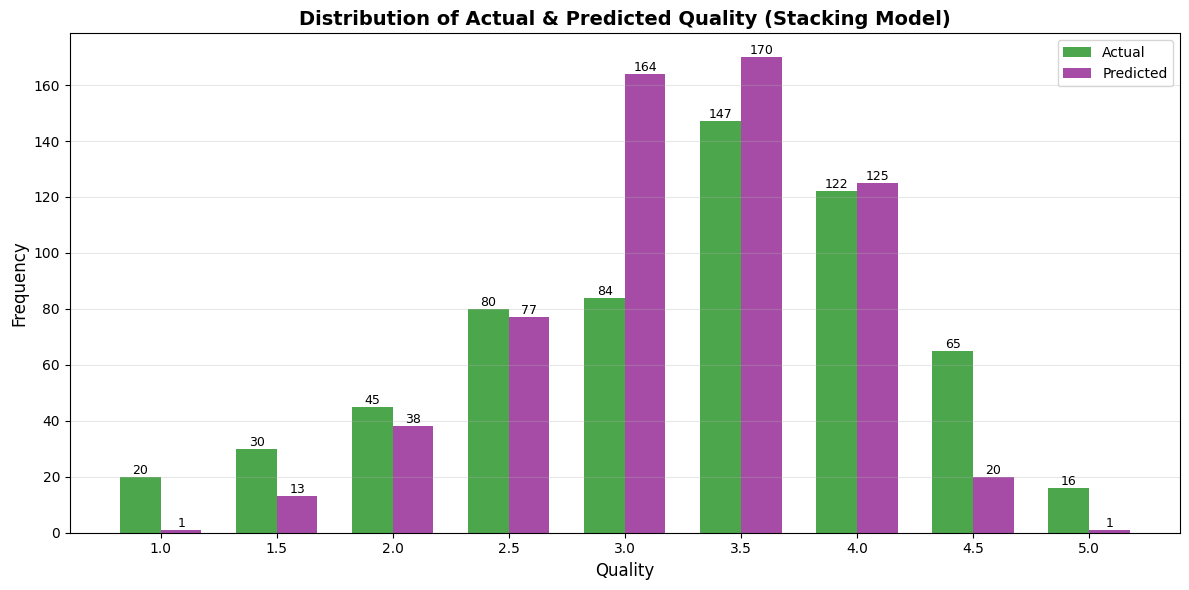


Distribution Summary:
Actual Quality Range: 1.00 - 5.00
Predicted Quality Range: 1.22 - 4.77


In [22]:
# ---------------- DISTRIBUTION OF ACTUAL VS PREDICTED (STACKING) ----------------
plt.figure(figsize=(12, 6))

# Get unique quality values and count frequencies
actual_array = np.array(all_actual)
stack_pred_array = np.array(all_preds["STACK"])

# Round predictions to match actual quality levels
stack_pred_rounded = np.round(stack_pred_array * 2) / 2  # Round to nearest 0.5

# Count frequencies
actual_counts = pd.Series(actual_array).value_counts().sort_index()
pred_counts = pd.Series(stack_pred_rounded).value_counts().sort_index()

# Get all unique quality levels
all_qualities = sorted(set(actual_counts.index) | set(pred_counts.index))

# Prepare data for plotting
actual_freq = [actual_counts.get(q, 0) for q in all_qualities]
pred_freq = [pred_counts.get(q, 0) for q in all_qualities]

# Create bar plot
x = np.arange(len(all_qualities))
width = 0.35

bars1 = plt.bar(x - width/2, actual_freq, width, label='Actual', color='green', alpha=0.7)
bars2 = plt.bar(x + width/2, pred_freq, width, label='Predicted', color='purple', alpha=0.7)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Actual & Predicted Quality (Stacking Model)', fontsize=14, fontweight='bold')
plt.xticks(x, all_qualities)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("distribution_actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDistribution Summary:")
print(f"Actual Quality Range: {actual_array.min():.2f} - {actual_array.max():.2f}")
print(f"Predicted Quality Range: {stack_pred_array.min():.2f} - {stack_pred_array.max():.2f}")

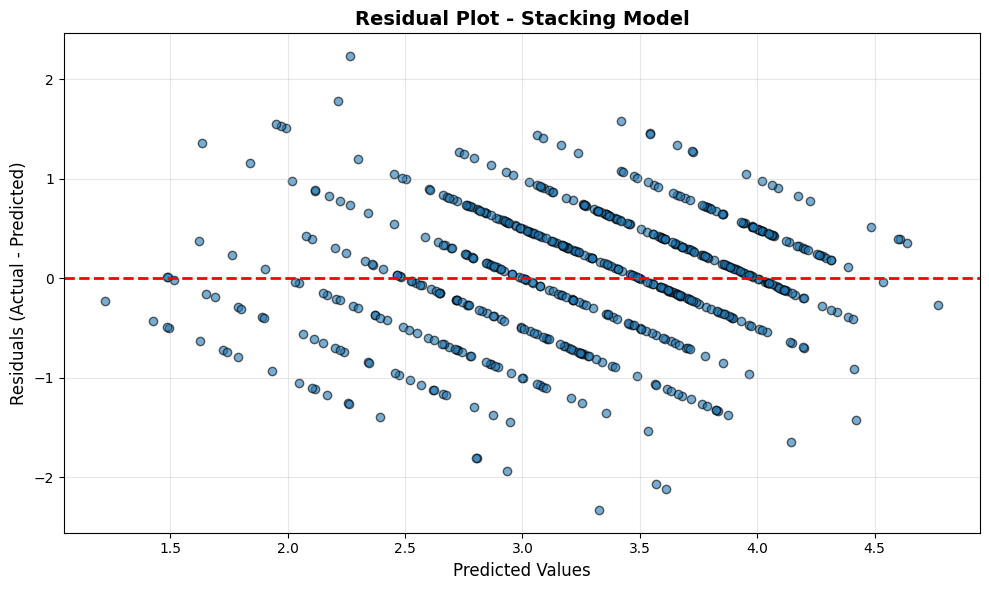


Residual Statistics:
Mean Residual: 0.0111
Std Residual: 0.6629
Min Residual: -2.3282
Max Residual: 2.2347


In [23]:
# ---------------- RESIDUAL PLOT (STACKING) ----------------
plt.figure(figsize=(10, 6))

residuals = actual_array - stack_pred_array

plt.scatter(stack_pred_array, residuals, alpha=0.6, edgecolors='black')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot - Stacking Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("residual_plot_stacking.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResidual Statistics:")
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")
print(f"Min Residual: {residuals.min():.4f}")
print(f"Max Residual: {residuals.max():.4f}")

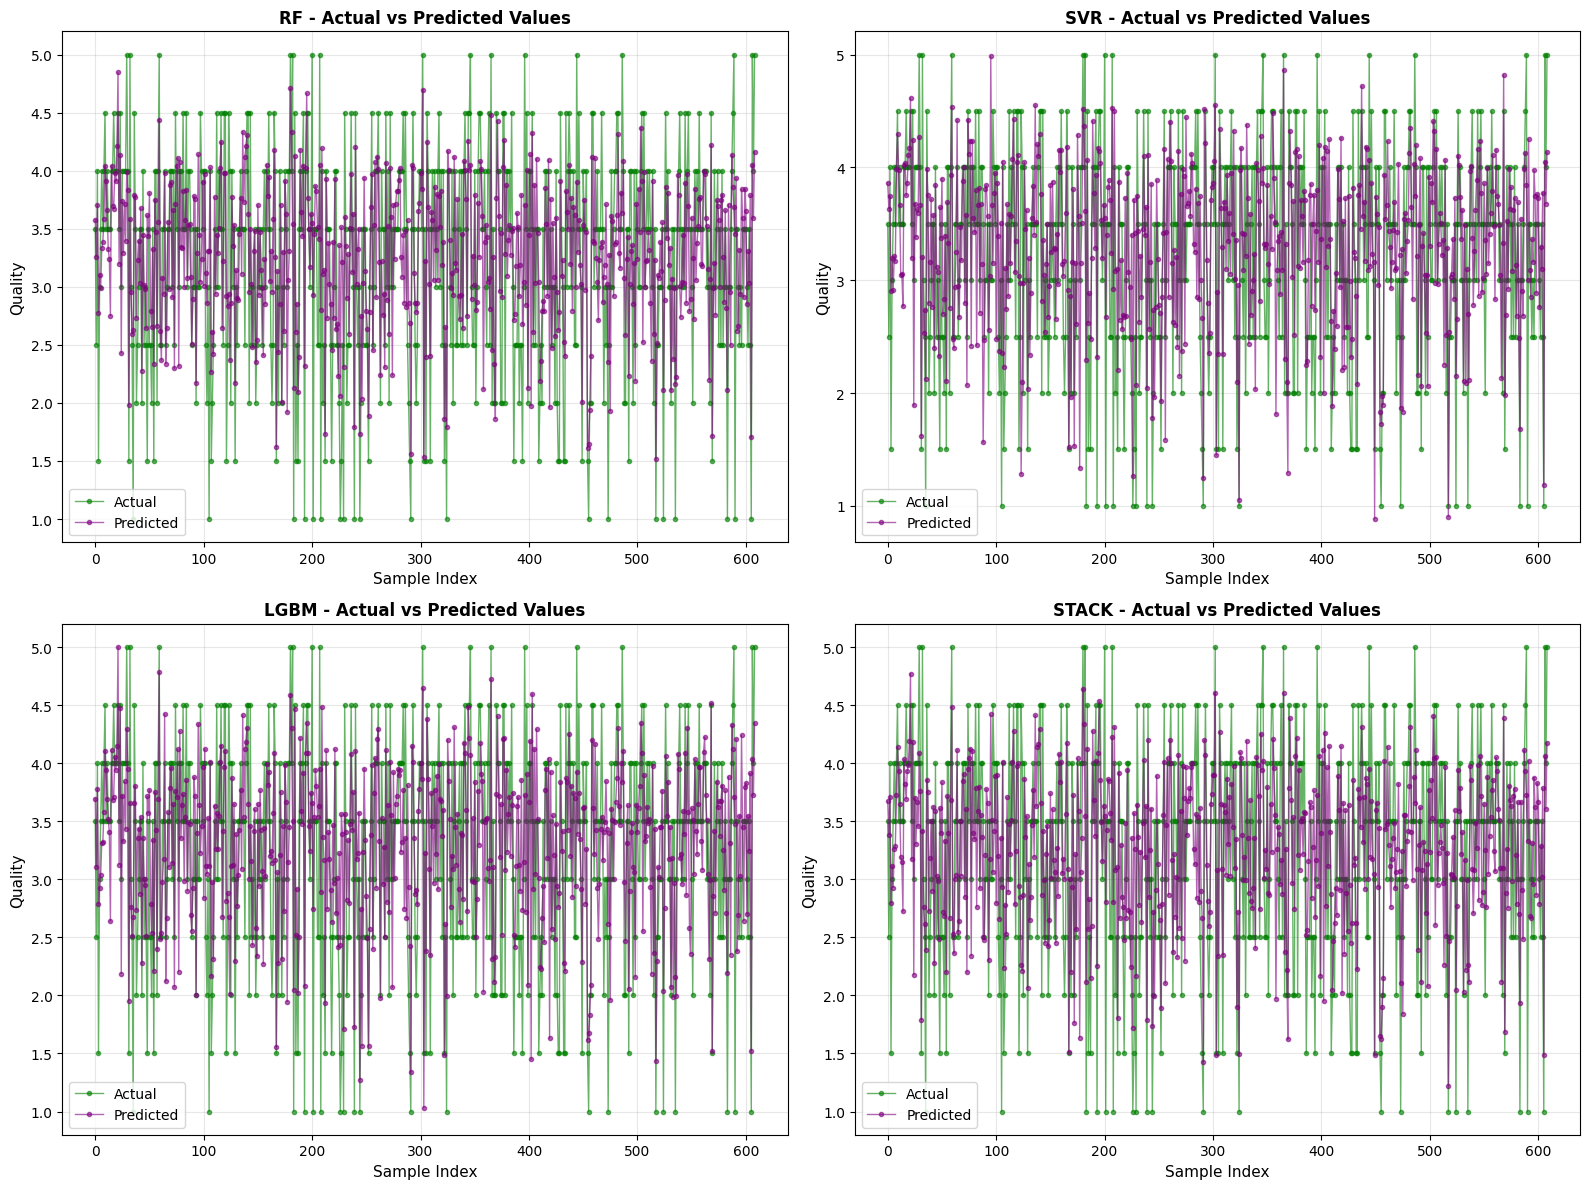

In [24]:
# ---------------- LINE PLOT: ACTUAL VS PREDICTED (ALL MODELS) ----------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models = ["RF", "SVR", "LGBM", "STACK"]
colors = {'Actual': 'green', 'Predicted': 'purple'}

for idx, model in enumerate(models):
    ax = axes[idx]
    pred_array = np.array(all_preds[model])
    
    # Create index for x-axis
    indices = np.arange(len(actual_array))
    
    # Plot actual and predicted
    ax.plot(indices, actual_array, 'o-', label='Actual', color='green', 
            alpha=0.6, markersize=3, linewidth=1)
    ax.plot(indices, pred_array, 'o-', label='Predicted', color='purple', 
            alpha=0.6, markersize=3, linewidth=1)
    
    ax.set_xlabel('Sample Index', fontsize=11)
    ax.set_ylabel('Quality', fontsize=11)
    ax.set_title(f'{model} - Actual vs Predicted Values', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("line_plot_actual_vs_predicted_all_models.png", dpi=300, bbox_inches='tight')
plt.show()

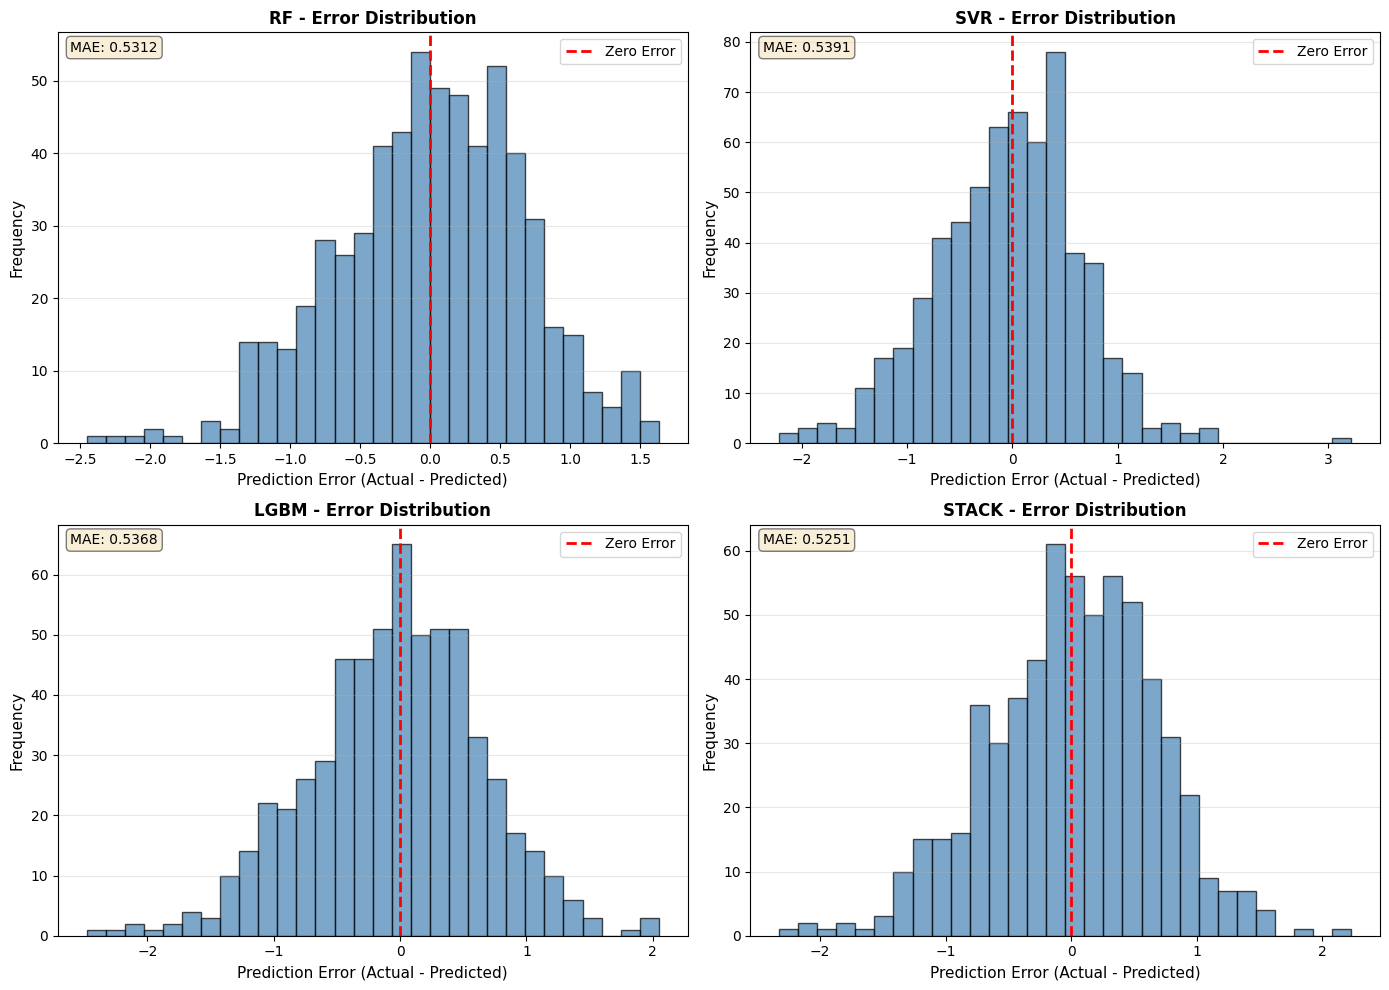

In [25]:
# ---------------- ERROR DISTRIBUTION (ALL MODELS) ----------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model in enumerate(models):
    ax = axes[idx]
    pred_array = np.array(all_preds[model])
    errors = actual_array - pred_array
    
    ax.hist(errors, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{model} - Error Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    mae = mean_absolute_error(actual_array, pred_array)
    ax.text(0.02, 0.98, f'MAE: {mae:.4f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("error_distribution_all_models.png", dpi=300, bbox_inches='tight')
plt.show()

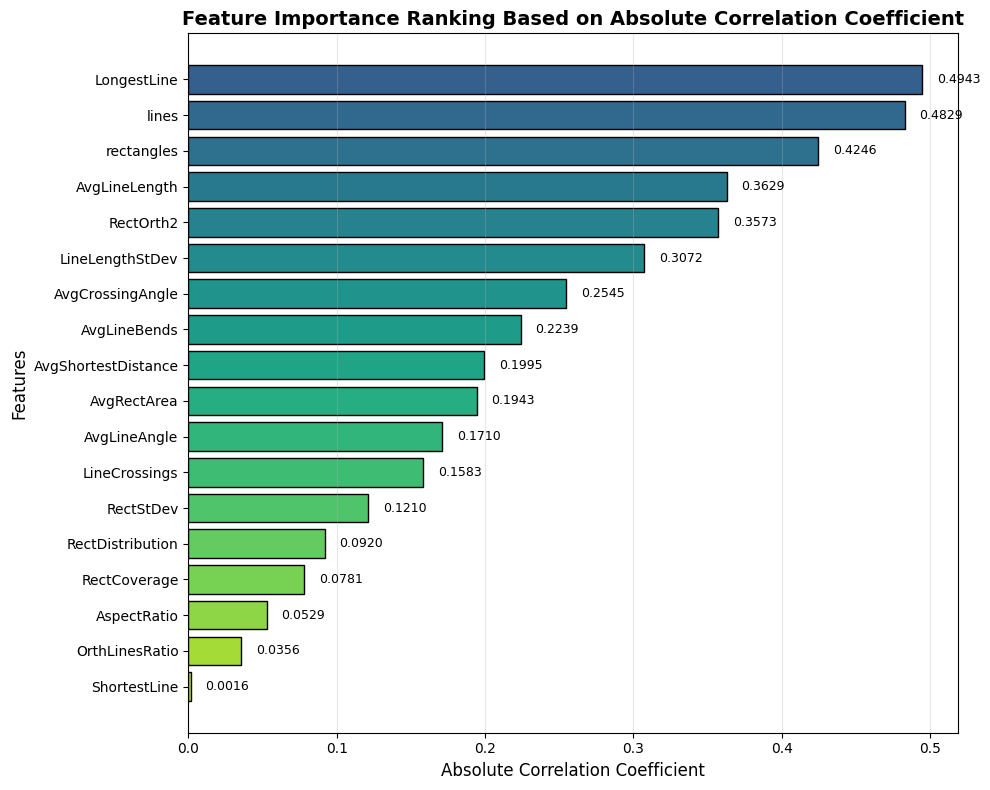


Feature Importance Ranking (Absolute Correlation):
 1. LongestLine                    : 0.4943
 2. lines                          : 0.4829
 3. rectangles                     : 0.4246
 4. AvgLineLength                  : 0.3629
 5. RectOrth2                      : 0.3573
 6. LineLengthStDev                : 0.3072
 7. AvgCrossingAngle               : 0.2545
 8. AvgLineBends                   : 0.2239
 9. AvgShortestDistance            : 0.1995
10. AvgRectArea                    : 0.1943
11. AvgLineAngle                   : 0.1710
12. LineCrossings                  : 0.1583
13. RectStDev                      : 0.1210
14. RectDistribution               : 0.0920
15. RectCoverage                   : 0.0781
16. AspectRatio                    : 0.0529
17. OrthLinesRatio                 : 0.0356
18. ShortestLine                   : 0.0016


In [26]:
# ---------------- FEATURE IMPORTANCE RANKING BASED ON ABSOLUTE CORRELATION ----------------
# Calculate correlation between each feature and target variable
correlations = X.corrwith(y).abs().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(correlations)))

bars = plt.barh(range(len(correlations)), correlations.values, color=colors, edgecolor='black')
plt.yticks(range(len(correlations)), correlations.index)
plt.xlabel('Absolute Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Ranking Based on Absolute Correlation Coefficient', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (idx, val) in enumerate(correlations.items()):
    plt.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("feature_importance_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Importance Ranking (Absolute Correlation):")
print("=" * 60)
for rank, (feature, corr) in enumerate(correlations.items(), 1):
    print(f"{rank:2d}. {feature:30s} : {corr:.4f}")
print("=" * 60)